In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [43]:
# factor data
data_factors = pd.read_csv('../data/indian_factors.csv')
# market data
data_market = pd.read_csv('../data/indian_market.csv')

# size data, should be part of all factors
data_size = pd.read_csv('../data/indian_size.csv')
# data_size['date'] = pd.to_datetime(data_size['date'], format='%d-%m-%Y')
# data_size['date'] = data_size['date'] + pd.offsets.MonthEnd()

# Risk free rate
data_risk_free = pd.read_csv('../data/indian_risk_free_rate.csv')
data_risk_free['date'] = pd.to_datetime(data_risk_free['date'], format='%d-%m-%Y')

# exchange rate data
fx = pd.read_csv('../data/exch.csv')

# Convert date to datetime and filter by 'INR'
fx['date'] = pd.to_datetime(fx['date'], format='%Y%m%d')
fx = fx[fx['curcdd'] == 'INR']

# Extract year and month for grouping
fx['year'] = fx['date'].dt.year
fx['month'] = fx['date'].dt.month

# Sort by date, group by year and month, and get the last value of 'fx' and 'date'
fx = fx.sort_values('date').groupby(['year', 'month']).agg({
    'fx': 'last',
    'date': 'last'
}).reset_index(drop=True)

# Adjust the 'date' to the end of the month
fx['eom'] = fx['date'] + pd.offsets.MonthEnd(0)

# Sort by 'eom' and calculate the percentage change in 'fx'
fx = fx.sort_values('eom')
fx['fx_ret'] = fx['fx'].pct_change()

# Filter out null values for 'fx_ret'
fx = fx[fx['fx_ret'].notna()]


factors_to_use = ['mkt', 'be_me', 'size', 'ret_12_1', 'qmj_growth','risk_free']

# Concatenate factors
factors = pd.concat([data_factors, data_market, data_size, data_risk_free])

# Convert date to datetime and filter relevant factors
factors['eom'] = pd.to_datetime(factors['date'], format='%Y-%m-%d')
factors = factors[factors['name'].isin(factors_to_use)]

# Pivot to wide format
factors = factors.pivot_table(index='eom', columns='name', values='ret')

# Join with fx data
factors = factors.merge(fx, on='eom', how='left')

# Adjusting factor returns with FX data
factors['be_me'] = ((factors['be_me'] + 1) * (factors['fx_ret'] + 1) - 1) * 100
factors['ret_12_1'] = ((factors['ret_12_1'] + 1) * (factors['fx_ret'] + 1) - 1) * 100
factors['mkt'] = ((factors['mkt'] + 1) * (factors['fx_ret'] + 1) - 1) * 100
factors['size'] = ((factors['size'] + 1) * (factors['fx_ret'] + 1) - 1) * 100
factors['qmj_growth'] = ((factors['qmj_growth'] + 1) * (factors['fx_ret'] + 1) - 1) * 100

# Drop unnecessary columns and filter by date range
factors = factors.drop(['fx', 'fx_ret'], axis=1)

In [44]:
factors = factors.dropna()
factors = factors.set_index('eom')

In [45]:
cpi_file = '../data/india_cpi.csv'

# Reading the data files
cpi_data = pd.read_csv(cpi_file, encoding='utf-8')

cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'], format='%d-%m-%Y')

cpi_data.rename(columns={'observation_date': 'Date', 'INDCPALTT01IXNBM': 'CPI'}, inplace=True)

cpi_data = cpi_data[['Date', 'CPI']]

cpi_data['Date'] = cpi_data['Date'].dt.to_period('M').dt.to_timestamp()

cpi_data = cpi_data.set_index('Date')
cpi_data = cpi_data.pct_change()*100
cpi_data = cpi_data.resample('M').first()

C:\Users\rmehta\AppData\Local\Temp\ipykernel_2380\3113124735.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi_data = cpi_data.resample('M').first()


## Regression where Y = momentum returns, X = CPI (monthly)

In [46]:
cpi_momentum = pd.merge(factors, cpi_data, left_index=True, right_index=True)

In [47]:
cpi_momentum['ret_12_1']

2004-08-31   -0.232704
2004-09-30   -1.427478
2004-10-31    2.959248
2004-11-30    3.289050
2004-12-31   -1.146147
                ...   
2023-07-31    1.741821
2023-08-31    2.450323
2023-09-30    3.017109
2023-10-31    0.803587
2023-11-30    3.527904
Name: ret_12_1, Length: 232, dtype: float64

In [48]:

# 1. Calculate Market Beta for Each Factor
# Define dependent (Y) and independent (X) variables
Y = cpi_momentum['ret_12_1'] # Excess returns of the factor
X = cpi_momentum['CPI']  # Excess market returns

# Add a constant for the regression intercept
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(Y, X).fit()

print(model.params)

const    0.457535
CPI     -0.271794
dtype: float64


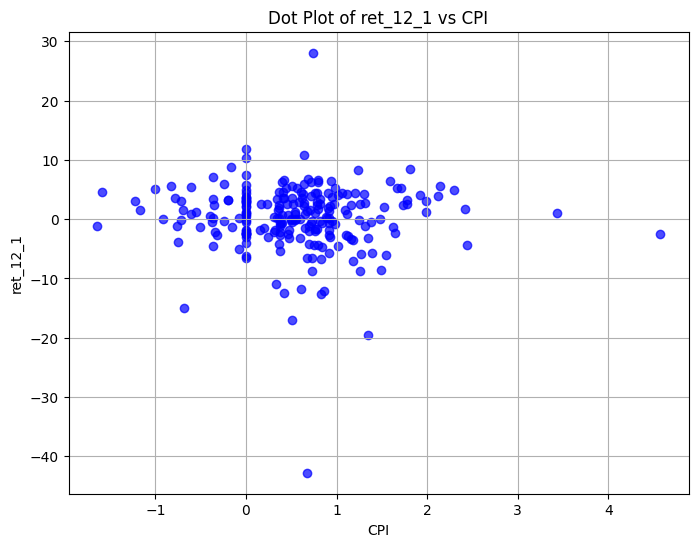

In [49]:
# Plot the data
# Create the dot plot
plt.figure(figsize=(8, 6))
plt.scatter(cpi_momentum['CPI'], cpi_momentum['ret_12_1'], color='blue', alpha=0.7)

# Add labels and title
plt.title('Dot Plot of ret_12_1 vs CPI')
plt.xlabel('CPI')
plt.ylabel('ret_12_1')
plt.grid(True)

# Show the plot
plt.show()

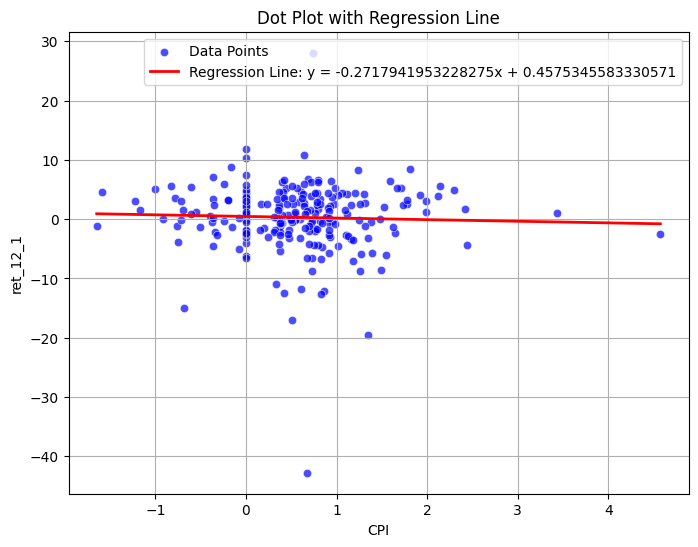

In [50]:
# Replace these with your actual constant and beta values
constant = model.params['const']  # Intercept
beta = model.params['CPI']     # Slope

# Calculate the regression line
x_values = np.linspace(cpi_momentum['CPI'].min(), cpi_momentum['CPI'].max(), 100)
y_values = beta * x_values + constant

# Create the scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cpi_momentum, x='CPI', y='ret_12_1', color='blue', alpha=0.7, label='Data Points')
plt.plot(x_values, y_values, color='red', label=f'Regression Line: y = {beta}x + {constant}', linewidth=2)

# Add labels and title
plt.title('Dot Plot with Regression Line')
plt.xlabel('CPI')
plt.ylabel('ret_12_1')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Regression where Y = momentum returns, X = CPI (quarterly)

In [51]:
cpi_data_q = cpi_data.resample('Q').first()
factors_q = factors.resample('Q').first()
cpi_momentum_q = pd.merge(factors_q, cpi_data_q, left_index=True, right_index=True)
cpi_momentum_q

C:\Users\rmehta\AppData\Local\Temp\ipykernel_2380\863687271.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  cpi_data_q = cpi_data.resample('Q').first()
C:\Users\rmehta\AppData\Local\Temp\ipykernel_2380\863687271.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  factors_q = factors.resample('Q').first()


,be_me,mkt,qmj_growth,ret_12_1,risk_free,size,date,CPI
2004-09-30,2.160833,2.312502,5.030853,-0.232704,0.404983,5.009113,2004-08-31,0.986244
2004-12-31,-4.156198,4.296652,8.228924,2.959248,0.396622,-1.052671,2004-10-31,0.584350
2005-03-31,-3.060216,-3.106695,-1.995336,2.562489,0.441657,-1.929646,2005-01-31,0.969141
2005-06-30,2.320658,-3.498941,-8.740378,-1.697202,0.404855,5.276796,2005-04-30,0.759301
2005-09-30,6.734300,7.163687,-10.372677,5.243864,0.421299,7.986586,2005-07-31,1.708114
...,...,...,...,...,...,...,...,...
2022-12-31,3.717974,-0.825083,0.218669,0.228584,0.516732,-2.035673,2022-10-31,0.913938
2023-03-31,4.911779,-2.076248,-0.852171,-2.664274,0.544402,4.126083,2023-01-31,0.377929
2023-06-30,4.762867,5.812131,1.415687,1.316632,0.505361,4.392962,2023-04-30,0.675169
2023-09-30,4.486509,3.136000,2.091436,1.741821,0.554291,4.320703,2023-07-31,2.419355


In [52]:
# Define dependent (Y) and independent (X) variables
Y = cpi_momentum_q['ret_12_1'] # Excess returns of the factor
X = cpi_momentum_q['CPI']  # Excess market returns

# Add a constant for the regression intercept
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(Y, X).fit()

print(model.params)

r_squared = model.rsquared
t_statistics = model.tvalues

# Display results
print(f"R-squared: {r_squared}")
print("T-statistics:")
print(t_statistics)

const    1.929112
CPI     -0.458624
dtype: float64
R-squared: 0.004815616915065268
T-statistics:
const    1.961936
CPI     -0.606430
dtype: float64


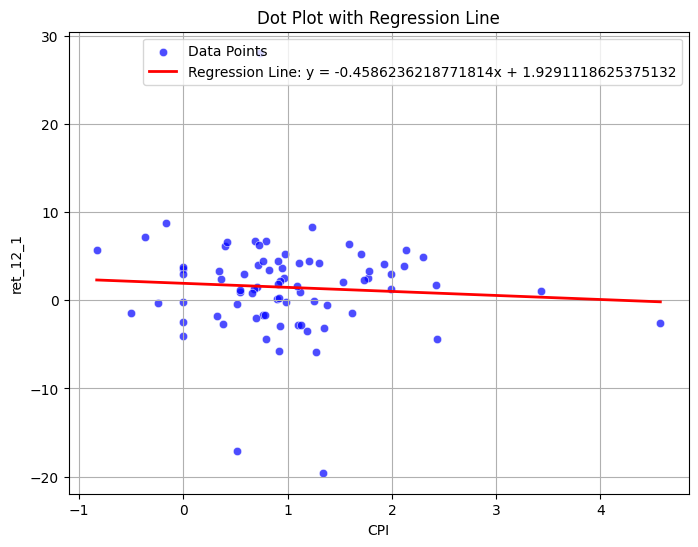

In [53]:
# Replace these with your actual constant and beta values
constant = model.params['const']  # Intercept
beta = model.params['CPI']     # Slope

# Calculate the regression line
x_values = np.linspace(cpi_momentum_q['CPI'].min(), cpi_momentum_q['CPI'].max(), 100)
y_values = beta * x_values + constant

# Create the scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cpi_momentum_q, x='CPI', y='ret_12_1', color='blue', alpha=0.7, label='Data Points')
plt.plot(x_values, y_values, color='red', label=f'Regression Line: y = {beta}x + {constant}', linewidth=2)

# Add labels and title
plt.title('Dot Plot with Regression Line')
plt.xlabel('CPI')
plt.ylabel('ret_12_1')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [54]:
cpi_momentum_q['CPI_lag1'] = cpi_momentum_q['CPI'].shift(1)

# Define dependent (Y) and independent (X) variables
Y = cpi_momentum_q['ret_12_1'].iloc[1:] # Excess returns of the factor
X = cpi_momentum_q['CPI_lag1'].iloc[1:]  # Excess market returns

# Add a constant for the regression intercept
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(Y, X).fit()

print(model.params)

const       1.089400
CPI_lag1    0.406699
dtype: float64


In [55]:
cpi_momentum_q['CPI_lag4'] = cpi_momentum_q['CPI'].shift(4)
cpi_momentum_q['CPI_lag4']

2004-09-30         NaN
2004-12-31         NaN
2005-03-31         NaN
2005-06-30         NaN
2005-09-30    0.986244
                ...   
2022-12-31    1.297648
2023-03-31   -0.239234
2023-06-30    1.349206
2023-09-30    0.541796
2023-12-31    0.913938
Freq: QE-DEC, Name: CPI_lag4, Length: 78, dtype: float64

In [56]:
# Define dependent (Y) and independent (X) variables
Y = cpi_momentum_q['ret_12_1'].iloc[4:] # Excess returns of the factor
X = cpi_momentum_q['CPI_lag4'].iloc[4:]  # Excess market returns

# Add a constant for the regression intercept
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(Y, X).fit()

print(model.params)

const       0.624739
CPI_lag4    0.886819
dtype: float64


## Quality minus junk

In [60]:
factors[['size','ret_12_1','qmj_growth']].corr()
factors['mkt_rf'] = factors['mkt'] -  factors['risk_free']

,size,ret_12_1,qmj_growth
size,1.000000,-0.290246,0.465902
ret_12_1,-0.290246,1.000000,0.102829
qmj_growth,0.465902,0.102829,1.000000


Market Betas:
{'qmj_growth': np.float64(0.318329921212095), 'ret_12_1': np.float64(-0.07565965880521229), 'size': np.float64(0.25248327369326384)}


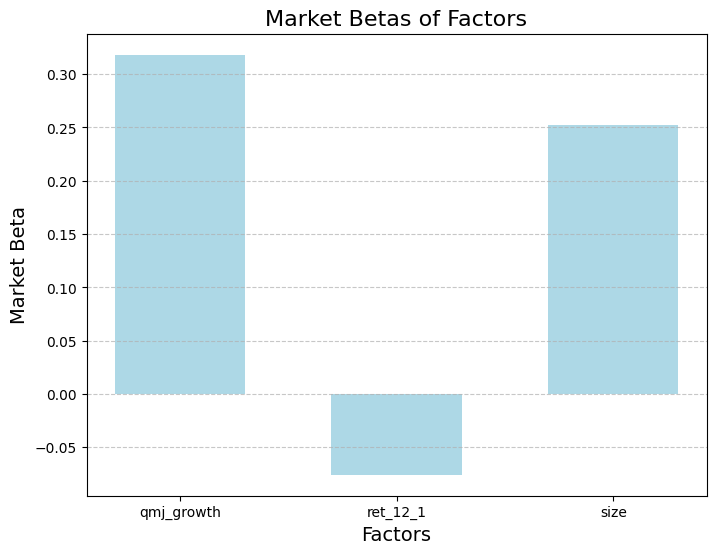

In [87]:
df = factors['2004-12-31':'2010-12-31']

# 1. Calculate Market Beta for Each Factor
betas = {}
for factor in ['qmj_growth', 'ret_12_1', 'size']:
    # Define dependent (Y) and independent (X) variables
    Y = df[factor] # Excess returns of the factor
    X = df['mkt_rf']  # Excess market returns
    
    # Add a constant for the regression intercept
    X = sm.add_constant(X)
    
    # Run the regression
    model = sm.OLS(Y, X).fit()
    betas[factor] = model.params['mkt_rf']  # Extract beta coefficient

print("Market Betas:")
print(betas)

colors = ['lightblue']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(betas.keys(), betas.values(), color=colors, width=0.6)  # Reduced width to 0.6

# Adding titles and labels
plt.title('Market Betas of Factors', fontsize=16)
plt.ylabel('Market Beta', fontsize=14)
plt.xlabel('Factors', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the bar plot
plt.show()


Annualized Alphas:
{'qmj_growth': np.float64(-5.632620688468743), 'ret_12_1': np.float64(2.552971533305869), 'size': np.float64(2.1742816136997294)}


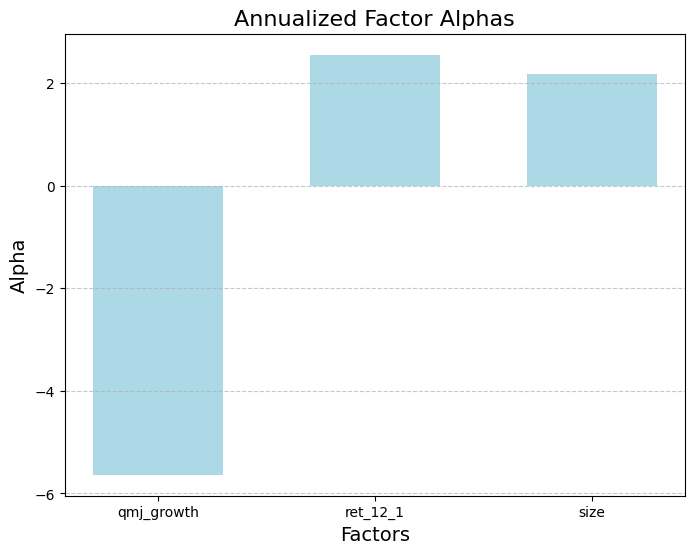

In [88]:
# 2. Calculate Alpha for Each Factor (Annualized)
alphas = {}
for factor in ['qmj_growth', 'ret_12_1', 'size']:
    # Define dependent (Y) and independent (X) variables
    Y = df[factor]  # Excess returns of the factor
    X = df['mkt_rf']  # Excess market returns
    
    # Add a constant for the regression intercept
    X = sm.add_constant(X)
    
    # Run the regression
    model = sm.OLS(Y, X).fit()
    
    # Extract monthly alpha (intercept)
    monthly_alpha = model.params['const']
    
    # Annualize the alpha: Multiply by 12
    annual_alpha = monthly_alpha * 12
    alphas[factor] = annual_alpha

print("\nAnnualized Alphas:")
print(alphas)

colors = ['lightblue']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(alphas.keys(), alphas.values(), color=colors, width=0.6)  # Reduced width to 0.6



# Adding titles and labels
plt.title('Annualized Factor Alphas', fontsize=16)
plt.ylabel('Alpha', fontsize=14)
plt.xlabel('Factors', fontsize=14)



plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the bar plot
plt.show()

In [77]:

factors

,be_me,mkt,qmj_growth,ret_12_1,risk_free,size,date,mkt_rf
eom,,,,,,,,
2004-08-31,2.160833,2.312502,5.030853,-0.232704,0.404983,5.009113,2004-08-31,1.907519
2004-09-30,0.961724,9.691089,1.311357,-1.427478,0.379771,3.469859,2004-09-30,9.311318
2004-10-31,-4.156198,4.296652,8.228924,2.959248,0.396622,-1.052671,2004-10-31,3.900030
2004-11-30,4.074436,14.190268,5.252057,3.289050,0.468178,5.413866,2004-11-30,13.722090
2004-12-31,11.539254,14.781318,0.546350,-1.146147,0.439720,8.561625,2004-12-31,14.341597
...,...,...,...,...,...,...,...,...
2023-08-31,0.414315,-1.114500,-0.384932,2.450323,0.559280,5.424298,2023-08-31,-1.673780
2023-09-30,6.259023,1.516996,3.206293,3.017109,0.526207,1.062427,2023-09-30,0.990789
2023-10-31,-1.454084,-3.422053,-1.121406,0.803587,0.585320,1.172556,2023-10-31,-4.007373


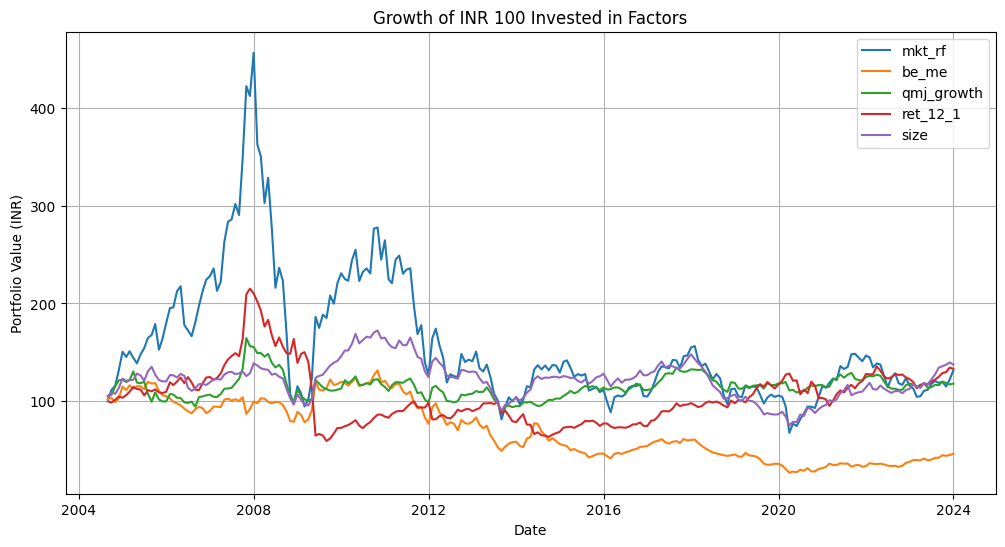

In [78]:

df = factors[['mkt_rf','be_me', 'qmj_growth', 'ret_12_1', 'size']]

# Set the 'date' column as index
# df.set_index('date', inplace=True)

# Initialize INR 100 investment
initial_investment = 100

# Calculate cumulative returns for each factor
cumulative_returns = (1 + df*0.01).cumprod() * initial_investment

# Plot the growth chart
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

# Add labels, legend, and title
plt.title('Growth of INR 100 Invested in Factors')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
factors('')